# Fine Tuning 
## Training Set Prep

In [7]:
import os
import json
import pathlib
import tarfile
import boto3
import numpy as np
import pandas as pd
import tensorflow as tf

pd.set_option('display.max_columns', None)

In [2]:
from boto3.session import Session

def aws_connect(service, profile='default', session=False):
    # Connect to AWS with IAM Role
    sess = Session(profile_name=profile)

    try:
        resource = sess.resource(service)
        client = resource.meta.client

        if session:
            return resource, client, sess
        else:
            return resource, client
    except:
        client = sess.client(service)

        if session:
            return client, sess
        else:
            return client

In [3]:
_, s3, boto_sess = aws_connect('s3', 'lw2134', session=True)

In [4]:
# Cards
s3.download_file('magicml-clean-data.prod', 'cards/cards.csv', 'cardsS3.csv')

In [4]:
# Embeddings
s3.download_file('magicml-inference.prod', 'use-large/arena_embeddings.csv', 'embeddings.csv')

In [5]:
# Load Model
use_embed = tf.saved_model.load('../services/models/use-large/1')

In [5]:
merge_cols = [
    'Names','id','mtgArenaId','scryfallId','name','colors','setName',
    'convertedManaCost','manaCost','loyalty','power','toughness',
    'type','types','subtypes','text','image_urls',
    'brawl','commander','duel','future','historic','legacy','modern',
    'oldschool','pauper','penny','pioneer','standard','vintage'
  ]

In [10]:
cards_df = pd.read_csv('cardsS3.csv')\
    .assign(Names=lambda df: df.name + '-' + df.id.astype('str'))\
    .assign(Names=lambda df: df.Names.apply(lambda x: x.replace(' ', '_').replace('//', 'II')))\
    .fillna('0')\
    [merge_cols]

#cards_txt = list(cards_df.text)
#cards_name = [
#    (name + '-' + str(id_val)).replace(' ','_').replace('//', 'II') for name, id_val in zip(cards_df.name, cards_df.id)
#]

print(cards_df.shape)
cards_df.head(2)

(8803, 30)
C:\Users\lwest\Anaconda3\envs\magicml\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (8,15,39,50) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Names,id,mtgArenaId,scryfallId,name,colors,setName,convertedManaCost,manaCost,loyalty,power,toughness,type,types,subtypes,text,image_urls,brawl,commander,duel,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
0,Archon_of_Sun's_Grace-4754,4754,74983,94f05268-0d4f-4638-aec3-a85fc339e3a7,Archon of Sun's Grace,W,Jumpstart Arena Exclusives,4.0,{2}{W}{W},0,3,4,Creature — Archon,Creature,Archon,"Flying, lifelink\nPegasus creatures you contro...",{'small': 'https://c1.scryfall.com/file/scryfa...,Legal,Legal,Legal,Legal,Legal,Legal,Legal,Blank,Blank,Legal,Legal,Legal,Legal
1,Banishing_Light-4755,4755,74986,ca112bae-6ac5-4cdf-9e8c-1b99f7396995,Banishing Light,W,Jumpstart Arena Exclusives,3.0,{2}{W},0,0,0,Enchantment,Enchantment,0,"When Banishing Light enters the battlefield, e...",{'small': 'https://c1.scryfall.com/file/scryfa...,Legal,Legal,Legal,Legal,Legal,Legal,Legal,Blank,Blank,Legal,Legal,Legal,Legal


In [16]:
subtypes = [_ for _ in list(set('-'.join(train_df.subtypes.unique()).replace(',','-').split('-')))]
len(subtypes)

240

In [50]:
train_cols = ['colors','types','text']

In [51]:
cards_df[train_cols].sample(10)

,colors,types,text
929,"G,R",Creature,Each other non-Human creature you control ente...
1986,0,Land,({T}: Add {U}.)
2970,R,Sorcery,Target Giant you control gets +2/+2 and gains ...
3568,0,Land,({T}: Add {G}.)
6245,B,Sorcery,Target opponent reveals their hand. You choose...
1536,G,Creature,Mutate {3}{G} (If you cast this spell for its ...
2981,U,Enchantment,As Reflections of Littjara enters the battlefi...
116,B,Enchantment,Enchant creature you control\nWhen Cartouche o...
2535,0,Land,Azorius Chancery enters the battlefield tapped...
2150,B,Sorcery,Return target creature card from your graveyar...


In [77]:
train_df = cards_df[train_cols]\
    .assign(cls=lambda df: (df.colors + '-' + df.types).str.replace(',','_'))\
    [['cls','text']]

print(train_df.shape)

#print('Unique colors: {}'.format(train_df.colors.nunique()))
#print('Unique basic type: {}'.format(train_df.types.nunique()))
#print('Unique subtypes: {}'.format(train_df.subtypes.nunique()))
#print('Unique fulltype: {}'.format(train_df.type.nunique()))
print('Unique cls: {}'.format(train_df.cls.nunique()))
train_df.sample(20)

(8803, 2)
Unique cls: 149


,cls,text
4863,R-Creature,Other Dwarves you control get +1/+0.\nWhenever...
7080,0-Land,Archway Commons enters the battlefield tapped....
3546,0-Land,Submerged Boneyard enters the battlefield tapp...
78,U-Enchantment,"Whenever you cycle or discard a card, you may ..."
2025,W-Creature,Flying\nWhenever you cast an enchantment spell...
7052,R_U-Creature,Flying\nInstant and sorcery spells you cast wi...
2832,0-Land,Skemfar Elderhall enters the battlefield tappe...
6619,W_B-Instant,Exile target card from a graveyard.\nDraw a card.
4454,W-Creature,Other creatures you control get +1/+1.
1488,0-Land,Bojuka Bog enters the battlefield tapped.\nWhe...


<AxesSubplot:>

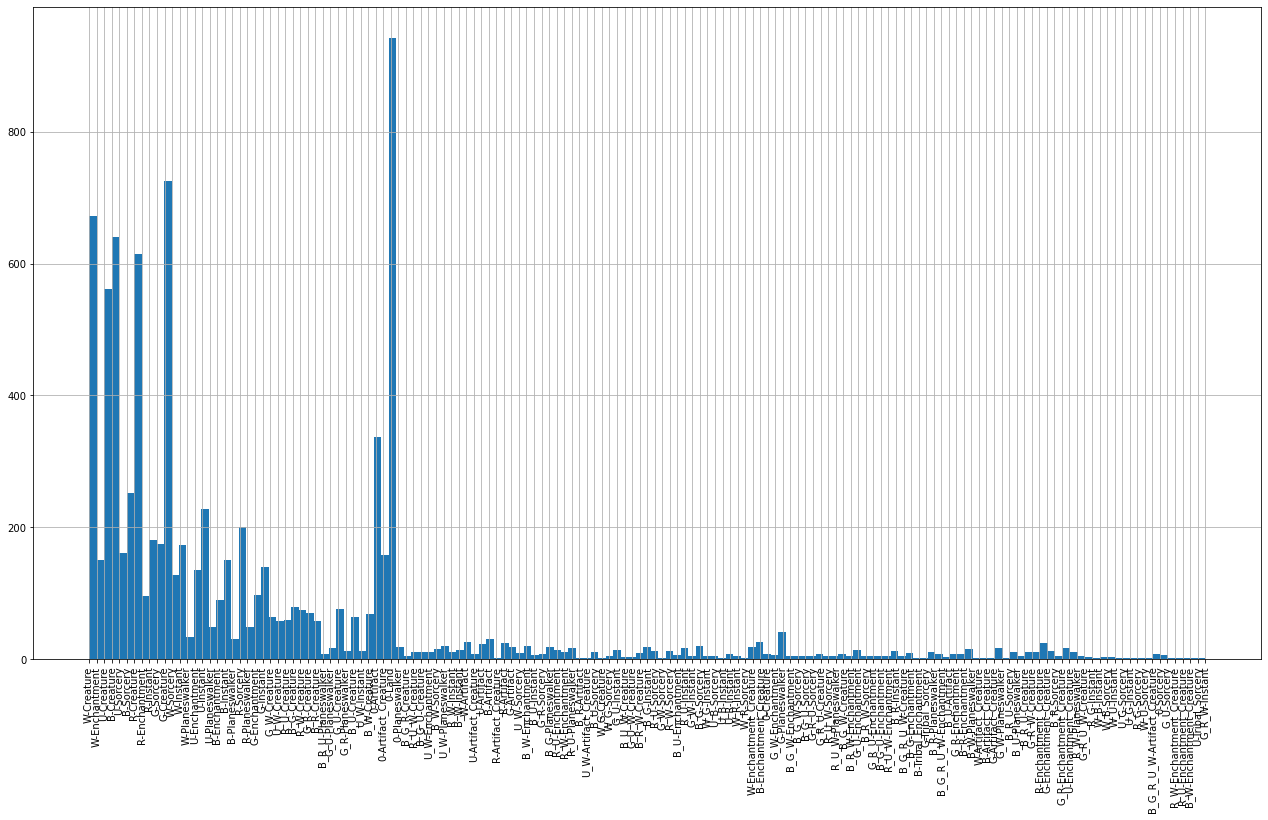

In [78]:
train_df.cls.hist(
    bins=train_df.cls.nunique(),
    figsize=(22,12),
    xrot=90
)

149
(45, 2)


<AxesSubplot:xlabel='cls'>

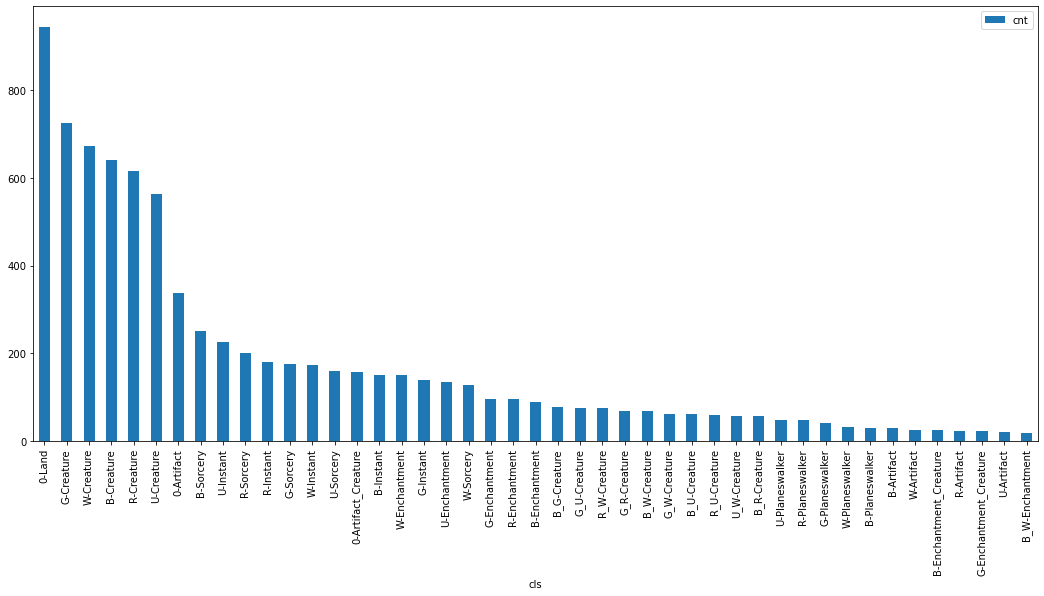

In [79]:
print(train_df.cls.nunique())

plot_df = train_df\
    .groupby('cls', as_index=False)\
    .agg(cnt=('text','count'))\
    .sort_values('cnt', ascending=False)\
    .query('cnt >= 20')

print(plot_df.shape)

plot_df\
    .plot.bar(
        x='cls',
        y='cnt',
        figsize=(18,8),
        rot=90
    )

In [114]:
pw = 'Planeswalker'

train_df\
    .groupby('cls', as_index=False)\
    .agg(cnt=('Names','count'))\
    .sort_values('cnt', ascending=False)\
    .query("`cls`.str.contains('Planeswalker')")

,cls,cnt
115,U - Planeswalker,47
89,R - Planeswalker,44
59,G - Planeswalker,39
135,W - Planeswalker,33
11,B - Planeswalker,28
4,0 - Planeswalker,18
16,"B,G - Planeswalker",18
127,"U,W - Planeswalker",17
81,"G,W - Planeswalker",16
97,"R,U - Planeswalker",16


In [56]:
for c in train_df.sample(5).text:
    print(c+'\n')

Each creature deals damage to itself equal to its power.

Choose one or both —
• Target creature gets -1/-1 until end of turn.
• Put a +1/+1 counter on target creature.

Whenever Selhoff Occultist or another creature dies, target player mills a card.

Target opponent reveals their hand. You choose a noncreature, nonland card from it. That player discards that card.

Whenever a creature you control attacks, it gets +1/+0 until end of turn for each other attacking creature that shares a creature type with it.



## Organize card text into folders by Class, like [HuggingFace example]('https://huggingface.co/transformers/custom_datasets.html')

In [80]:
cls_list = list(train_df.cls.unique())

In [81]:
train_df.head(3)

,cls,text
0,W-Creature,"Flying, lifelink\nPegasus creatures you contro..."
1,W-Enchantment,"When Banishing Light enters the battlefield, e..."
2,U-Creature,"When Gadwick, the Wizened enters the battlefie..."


## Make cls directories

In [125]:
base_dir = '../data/fine_tune'
target_dir = '/cls'
cls_dir = pathlib.Path(base_dir + target_dir)

for c in train_df.cls.unique():
    (cls_dir/c).mkdir(parents=True, exist_ok=True)

## Build dataset as text file for each card text in class directories

In [126]:
for i, z in enumerate(zip(train_df.cls, train_df.text)):
    c, txt = z
    f = '{}_{}.txt'.format(i, c)
    (cls_dir/c/f).write_text(txt, encoding='utf-8')

## Load Training Data

In [132]:
cls_idx = {cls_list[idx]: idx for idx in range(len(cls_list))}

In [138]:
from pathlib import Path

def load_fine_tuning_data(target_dir, label_idx):
    target_dir = Path(target_dir)
    texts = []
    labels = []
    for label_dir in label_idx.keys():
        for txt_file in (target_dir/label_dir).iterdir():
            texts.append(txt_file.read_text())
            labels.append(label_idx[label_dir])

    return texts, labels

In [139]:
train_texts, train_labels = load_fine_tuning_data('../data/fine_tune/cls', cls_idx)
#test_texts, test_labels = read_imdb_split('aclImdb/test')

## Split in Training and Validation  

### Have to handle fact that some classes only have 1 example!!!

In [148]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.1)

## Tokenize and Pad

In [150]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading: 100%|██████████| 232k/232k [00:00<00:00, 3.02MB/s]
Downloading: 100%|██████████| 466k/466k [00:00<00:00, 4.00MB/s]
Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 14.0kB/s]


In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
#test_encodings = tokenizer(test_texts, truncation=True, padding=True)

## Convert to TFDataset

In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

#test_dataset = tf.data.Dataset.from_tensor_slices((
#    dict(test_encodings),
#    test_labels
#))

## Train

In [ ]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = TFTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

In [ ]:
trainer.train()

In [30]:
# Test Free Text Query
query = 'extra_turn'
embed_query = use_embed([query])
print(embed_query.shape)

(1, 512)


In [13]:
sim = np.inner(all_embeds, embed_query)
print(sim.shape)

(7998, 1)


In [31]:
sims_list = pd.DataFrame(sim, columns=['free_text_query'], index=cards_name)\
    .sort_values(by='free_text_query', ascending=False)\
    .head(50)\
    .reset_index()\
    .rename(columns={'index':'Names', 'free_text_query':'similarity'})\
    .merge(cards_df, how='left', on='Names')\
    .assign(similarity=lambda df: df.similarity.astype('str'))\
    .assign(id=lambda df: df.id.astype('str'))\
    .assign(mtgArenaId=lambda df: df.mtgArenaId.astype('str'))\
    .assign(loyalty=lambda df: df.loyalty.astype('str'))\
    .assign(power=lambda df: df.power.astype('str'))\
    .assign(toughness=lambda df: df.toughness.astype('str'))\
    .assign(convertedManaCost=lambda df: df.convertedManaCost.astype('str'))\
    .to_dict(orient='records')

sims_list[0]

{'Names': 'Time_Warp-17722',
 'similarity': '0.44100022',
 'id': '17722',
 'mtgArenaId': '0',
 'scryfallId': '87fe8637-9be1-4b57-832f-38cf92d23482',
 'name': 'Time Warp',
 'colors': 'U',
 'setName': 'Explorers of Ixalan',
 'convertedManaCost': '5.0',
 'manaCost': '{3}{U}{U}',
 'loyalty': '0',
 'power': '0',
 'toughness': '0',
 'type': 'Sorcery',
 'types': 'Sorcery',
 'subtypes': '0',
 'text': 'Target player takes an extra turn after this one.',
 'image_urls': "{'small': 'https://c1.scryfall.com/file/scryfall-cards/small/front/8/7/87fe8637-9be1-4b57-832f-38cf92d23482.jpg?1562927104', 'normal': 'https://c1.scryfall.com/file/scryfall-cards/normal/front/8/7/87fe8637-9be1-4b57-832f-38cf92d23482.jpg?1562927104', 'large': 'https://c1.scryfall.com/file/scryfall-cards/large/front/8/7/87fe8637-9be1-4b57-832f-38cf92d23482.jpg?1562927104', 'png': 'https://c1.scryfall.com/file/scryfall-cards/png/front/8/7/87fe8637-9be1-4b57-832f-38cf92d23482.png?1562927104', 'art_crop': 'https://c1.scryfall.com/fil

In [32]:
Item = {
    'freeText': query,
    'similarities': sims_list
}

In [11]:
merge_cols = [
    'Names','id','mtgArenaId','scryfallId','name','colors','setName',
    'convertedManaCost','manaCost','loyalty','power','toughness',
    'type','types','subtypes','text','image_urls',
    'brawl','commander','duel','future','historic','legacy','modern',
    'oldschool','pauper','penny','pioneer','standard','vintage'
]

cards_df = pd.read_csv('cards.csv')\
    .query('mtgArenaId.notnull()')\
    .assign(Names=lambda df: df.name + '-' + df.id.astype('str'))\
    .assign(Names=lambda df: df.Names.apply(lambda x: x.replace(' ', '_').replace('//', 'II')))\
    .fillna('0')\
    [merge_cols]

print(cards_df.shape)
cards_df.head(2)

(5419, 30)


,Names,id,mtgArenaId,scryfallId,name,colors,setName,convertedManaCost,manaCost,loyalty,...,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
4753,Archon_of_Sun's_Grace-4754,4754,74983.0,94f05268-0d4f-4638-aec3-a85fc339e3a7,Archon of Sun's Grace,W,Jumpstart Arena Exclusives,4.0,{2}{W}{W},0,...,Legal,Legal,Legal,Legal,Blank,Blank,Blank,Legal,Legal,Legal
4754,Audacious_Thief-4755,4755,74991.0,ba315deb-d5a9-4013-b6ef-e4efe652e569,Audacious Thief,B,Jumpstart Arena Exclusives,3.0,{2}{B},0,...,Blank,Legal,Legal,Legal,Blank,Legal,Blank,Legal,Blank,Legal


In [29]:
embed_df.columns.nunique()

5420

In [30]:
cards_df.query('Names == "Zof_Consumption_II_Zof_Bloodbog-55942"')

,Names,id,mtgArenaId,scryfallId,name,colors,setName,convertedManaCost,manaCost,loyalty,...,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
55941,Zof_Consumption_II_Zof_Bloodbog-55942,55942,73331.0,98496d5b-1519-4f0c-8b46-0a43be643dfb,Zof Consumption // Zof Bloodbog,B,Zendikar Rising,6.0,{4}{B}{B},0,...,Legal,Legal,Legal,Legal,Blank,Blank,Legal,Legal,Legal,Legal


In [362]:
all_cards = embed_df.columns

BATCH_SIZE = 100
batches = [list(all_cards[n:n+BATCH_SIZE]) for n in range(1, len(all_cards), BATCH_SIZE)]

In [21]:
merge_cols = [
    'Names','id','mtgArenaId','scryfallId','name','colors','setName',
    'convertedManaCost','manaCost','loyalty','power','toughness',
    'type','types','subtypes','text',
    'brawl','commander','duel','future','historic','legacy','modern',
    'oldschool','pauper','penny','pioneer','standard','vintage'
]

In [22]:
cards_df = pd.read_csv('cards.csv')\
    .query('mtgArenaId.notnull()')\
    .assign(Names=lambda df: df.name + '-' + df.id.astype('str'))\
    .assign(Names=lambda df: df.Names.apply(lambda x: x.replace(' ', '_').replace('//', 'II')))\
    .fillna('0')\
    [merge_cols]

print(cards_df.shape)
cards_df.head(3)

(5419, 29)


,Names,id,mtgArenaId,scryfallId,name,colors,setName,convertedManaCost,manaCost,loyalty,...,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
4753,Archon_of_Sun's_Grace-4754,4754,74983.0,94f05268-0d4f-4638-aec3-a85fc339e3a7,Archon of Sun's Grace,W,Jumpstart Arena Exclusives,4.0,{2}{W}{W},0,...,Legal,Legal,Legal,Legal,Blank,Blank,Blank,Legal,Legal,Legal
4754,Audacious_Thief-4755,4755,74991.0,ba315deb-d5a9-4013-b6ef-e4efe652e569,Audacious Thief,B,Jumpstart Arena Exclusives,3.0,{2}{B},0,...,Blank,Legal,Legal,Legal,Blank,Legal,Blank,Legal,Blank,Legal
4755,Banishing_Light-4756,4756,74986.0,ca112bae-6ac5-4cdf-9e8c-1b99f7396995,Banishing Light,W,Jumpstart Arena Exclusives,3.0,{2}{W},0,...,Legal,Legal,Legal,Legal,Blank,Blank,Legal,Legal,Legal,Legal


In [23]:
cards_df.Names.nunique()

5419

In [24]:
cards_df.name.nunique()

4267

In [25]:
cards_df.scryfallId.nunique()

5283

In [38]:
card = 'Oreskos_Swiftclaw-28847'

In [44]:
staged_card = embed_df[['Names', card]]\
    .merge(cards_df, how='left', on='Names')

Item = staged_card.query('Names == @card').to_dict(orient='records')

staged_card = staged_card\
    .sort_values(by=card, ascending=False)\
    .head(51)\
    .rename(columns={card: 'similarity'})\
    .assign(similarity=lambda df: df.similarity.astype('str'))\
    .assign(id=lambda df: df.id.astype('str'))\
    .assign(mtgArenaId=lambda df: df.mtgArenaId.astype('str'))\
    .assign(loyalty=lambda df: df.loyalty.astype('str'))\
    .assign(power=lambda df: df.power.astype('str'))\
    .assign(toughness=lambda df: df.toughness.astype('str'))\
    .assign(convertedManaCost=lambda df: df.convertedManaCost.astype('str'))

staged_card

,Names,similarity,id,mtgArenaId,scryfallId,name,colors,setName,convertedManaCost,manaCost,...,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
3884,Axebane_Beast-45872,0.9999998999999999,45872,69249.0,2f420b35-1f73-41c8-a15f-1aee4af0999c,Axebane Beast,G,Ravnica Allegiance,4.0,{3}{G},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal
3684,Canal_Monitor-45672,0.9999998999999999,45672,66743.0,78226edc-87dd-4c38-987c-52aefe0f9531,Canal Monitor,B,Rivals of Ixalan,5.0,{4}{B},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal
2901,Tolarian_Scholar-28942,0.9999998999999999,28942,67840.0,2eda67da-02b5-4ecb-9038-10e026d454ec,Tolarian Scholar,U,Core Set 2019,3.0,{2}{U},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal
4864,Headwater_Sentries-54863,0.9999998999999999,54863,66077.0,2af2c338-f5e9-4596-9435-c6aa965ae541,Headwater Sentries,U,Ixalan,4.0,{3}{U},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal
427,Armored_Whirl_Turtle-5931,0.9999998999999999,5931,75465.0,44a783f2-04d3-42fc-acc1-5f2974f9aca2,Armored Whirl Turtle,U,Arena Beginner Set,3.0,{2}{U},...,Blank,Legal,Legal,Blank,Blank,Legal,Blank,Blank,Blank,Legal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3598,Treetop_Warden-35145,0.9999998999999999,35145,69119.0,771341f5-11b2-4edc-aa41-088e852c058e,Treetop Warden,G,Arena New Player Experience Cards,2.0,{1}{G},...,Blank,Legal,Blank,Blank,Blank,Blank,Blank,Blank,Blank,Blank
4749,Rumbling_Baloth-54748,0.9999998999999999,54748,68801.0,a366fd5c-f6cd-4773-a25d-6114e11238cc,Rumbling Baloth,G,Arena New Player Experience Extras,4.0,{2}{G}{G},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal
3053,Goblin_Assailant-29095,0.9999998999999999,29095,70114.0,8cfefb65-b6e4-44a1-baa9-d3c00ee8ba96,Goblin Assailant,R,Core Set 2020,2.0,{1}{R},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal
786,Tolarian_Scholar-16832,0.9999998999999999,16832,67246.0,00d89839-60d7-4de2-a78a-1afdcc21c053,Tolarian Scholar,U,Dominaria,3.0,{2}{U},...,Blank,Legal,Legal,Legal,Blank,Legal,Legal,Legal,Blank,Legal


In [40]:
Item = staged_card.query('Names == @card').to_dict(orient='records')
Item

[{'Names': 'Oreskos_Swiftclaw-28847',
  'similarity': '0.9999998999999999',
  'id': '28847',
  'mtgArenaId': '67742.0',
  'scryfallId': '0ea1dfb4-1983-41f7-956c-f2a1d1489b54',
  'name': 'Oreskos Swiftclaw',
  'colors': 'W',
  'setName': 'Core Set 2019',
  'convertedManaCost': '2.0',
  'manaCost': '{1}{W}',
  'loyalty': '0',
  'power': '3',
  'toughness': '1',
  'type': 'Creature — Cat Warrior',
  'types': 'Creature',
  'subtypes': 'Cat,Warrior',
  'text': '0',
  'brawl': 'Blank',
  'commander': 'Legal',
  'duel': 'Legal',
  'future': 'Blank',
  'historic': 'Legal',
  'legacy': 'Legal',
  'modern': 'Legal',
  'oldschool': 'Blank',
  'pauper': 'Legal',
  'penny': 'Legal',
  'pioneer': 'Legal',
  'standard': 'Blank',
  'vintage': 'Legal'}]

## Get card item from Dyanmo

In [1]:
import os
import json
import boto3
from boto3.dynamodb.conditions import Key

In [2]:
SIMILARITY_TABLE = 'similarity-dev'

In [3]:
boto_sess = boto3.Session(profile_name='lw2134')
dynamodb = boto_sess.resource('dynamodb')
table = dynamodb.Table(SIMILARITY_TABLE)

In [8]:
# QUERY CARD BY NAME CONTAINS
card_item = table.query(
    KeyConditions={
        'name': {
            'AttributeValueList': ['Banishing'],
            'ComparisonOperator': 'BEGINS_WITH'
        }
    }
)

print(card_item)
#print(card_item['Items'][0]['name'])
#print(len(card_item['Items']))
#print(card_item['Items'][0]['text'])

ClientError: An error occurred (ValidationException) when calling the Query operation: Query key condition not supported

In [323]:
# QUERY BY NAME
card_item = table.query(
    KeyConditionExpression=Key('name').eq("Bontu's Last Reckoning")
)

print(card_item['Items'][0]['name'])
print(len(card_item['Items']))
print(card_item['Items'][0]['text'])

Bontu's Last Reckoning
1
Destroy all creatures. Lands you control don't untap during your next untap step.


## Call deployed API

In [10]:
import requests

### Scryfall Card Search API

In [23]:
q = 'garruk cursed'

In [24]:
res = requests.get('https://api.scryfall.com/cards/search?q={}'.format(q))

In [25]:
res.json()

{'object': 'list',
 'total_cards': 2,
 'has_more': False,
 'data': [{'object': 'card',
   'id': 'abef512f-8f1d-4257-b16f-c0eed58670ec',
   'oracle_id': 'e0cef79c-ad47-4cbc-9d73-a913e487ccb7',
   'multiverse_ids': [473153],
   'mtgo_id': 78526,
   'arena_id': 70338,
   'tcgplayer_id': 198500,
   'cardmarket_id': 398939,
   'name': 'Garruk, Cursed Huntsman',
   'lang': 'en',
   'released_at': '2019-10-04',
   'uri': 'https://api.scryfall.com/cards/abef512f-8f1d-4257-b16f-c0eed58670ec',
   'scryfall_uri': 'https://scryfall.com/card/eld/191/garruk-cursed-huntsman?utm_source=api',
   'layout': 'normal',
   'highres_image': True,
   'image_uris': {'small': 'https://c1.scryfall.com/file/scryfall-cards/small/front/a/b/abef512f-8f1d-4257-b16f-c0eed58670ec.jpg?1572490758',
    'normal': 'https://c1.scryfall.com/file/scryfall-cards/normal/front/a/b/abef512f-8f1d-4257-b16f-c0eed58670ec.jpg?1572490758',
    'large': 'https://c1.scryfall.com/file/scryfall-cards/large/front/a/b/abef512f-8f1d-4257-b16

### MagicML Semantic Search API

In [390]:
query = {
  "key": "name",
  "value": "Murder"
}

In [393]:
res = requests.post('https://38axjswipg.execute-api.us-east-1.amazonaws.com/dev/query', json=query)

if len(res.json()['cards']) > 0:
    print(res.json()['cards'][0]['Names'])
    print(res.json()['cards'][0]['name'])
    print(len(res.json()['cards']))
else:
    print(res.json()['cards'])

Murder-29173
Murder
1


In [394]:
res.json()

{'cards': [{'subtypes': '0',
   'setName': 'Core Set 2020',
   'duel': 'Legal',
   'mtgArenaId': '69894.0',
   'scryfallId': '6a2b22bc-e81b-4f27-a52b-9f3edad25439',
   'types': 'Instant',
   'brawl': 'Blank',
   'name': 'Murder',
   'penny': 'Legal',
   'pioneer': 'Legal',
   'convertedManaCost': '3.0',
   'modern': 'Legal',
   'colors': 'B',
   'id': '29173',
   'future': 'Blank',
   'historic': 'Legal',
   'commander': 'Legal',
   'toughness': '0',
   'loyalty': '0',
   'pauper': 'Legal',
   'Names': 'Murder-29173',
   'text': 'Destroy target creature.',
   'image_urls': "{'small': 'https://c1.scryfall.com/file/scryfall-cards/small/front/6/a/6a2b22bc-e81b-4f27-a52b-9f3edad25439.jpg?1592516737', 'normal': 'https://c1.scryfall.com/file/scryfall-cards/normal/front/6/a/6a2b22bc-e81b-4f27-a52b-9f3edad25439.jpg?1592516737', 'large': 'https://c1.scryfall.com/file/scryfall-cards/large/front/6/a/6a2b22bc-e81b-4f27-a52b-9f3edad25439.jpg?1592516737', 'png': 'https://c1.scryfall.com/file/scryfal

## Lambda Cards Sorter Master

In [39]:
STAGE = 'dev'

In [40]:
_, s3, boto_sess = aws_connect('s3', 'lw2134', session=True)
lambda_client = boto_sess.client('lambda')

In [41]:
all_cards = pred_df.columns

In [47]:
BATCHES_OF = 10
batches = [list(all_cards[n:n+BATCHES_OF]) for n in range(1, len(all_cards), BATCHES_OF)]
print(len(batches))
batches[0]

542


["Archon_of_Sun's_Grace-AJMP",
 'Audacious_Thief-AJMP',
 'Banishing_Light-AJMP',
 'Bond_of_Revival-AJMP',
 'Carnifex_Demon-AJMP',
 'Doomed_Necromancer-AJMP',
 'Dryad_Greenseeker-AJMP',
 'Fanatic_of_Mogis-AJMP',
 'Gadwick,_the_Wizened-AJMP',
 'Goblin_Oriflamme-AJMP']

In [49]:
import json

In [54]:
json.dumps(batches[0][0:5])

'["Archon_of_Sun\'s_Grace-AJMP", "Audacious_Thief-AJMP", "Banishing_Light-AJMP", "Bond_of_Revival-AJMP", "Carnifex_Demon-AJMP"]'

In [141]:
for cards in batches:
    payload = {'cards': cards}

    res = lambda_client.invoke(
        FunctionName='magicml-similarity-{}-stage_embed_worker'.format(STAGE),
        InvocationType='Event',
        Payload=json.dumps(payload)
    )

In [142]:
a_card = pd.read_csv('sorted/Banishing_Light-AJMP.csv')
print(a_card.shape)

(7639, 33)


In [149]:
a_card.head(3)

,Banishing_Light-AJMP,id,mtgArenaId,scryfallId,name,colorIdentity,colors,setName,convertedManaCost,manaCost,...,future,historic,legacy,modern,oldschool,pauper,penny,pioneer,standard,vintage
0,1.000000,4756,74986.0,ca112bae-6ac5-4cdf-9e8c-1b99f7396995,Banishing Light,W,W,Jumpstart Arena Exclusives,3.0,{2}{W},...,Legal,Legal,Legal,Legal,Blank,Blank,Legal,Legal,Legal,Legal
1,1.000000,49136,70515.0,a1ddd113-140f-49c9-b45c-cf1b0d1dffd8,Banishing Light,W,W,Theros Beyond Death,3.0,{2}{W},...,Legal,Legal,Legal,Legal,Blank,Blank,Legal,Legal,Legal,Legal
2,0.773027,28775,67708.0,197743cd-249c-42ba-ac8d-027c088f8418,Hieromancer's Cage,W,W,Core Set 2019,4.0,{3}{W},...,Blank,Legal,Legal,Legal,Blank,Blank,Blank,Legal,Blank,Legal
